# Newsgroup20 Classification

In [18]:
import itertools
import scipy
import numpy as np
import pandas as pd
import logging

import gensim
from gensim.models import word2vec, doc2vec

import sklearn
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier, Perceptron

import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer

import matplotlib
import matplotlib.pyplot as plt

import bokeh
from bokeh.plotting import figure, output_file, show

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
bokeh.plotting.output_notebook()

Loading BokehJS ...

In [134]:
REMOVE = ('headers', 'footers', 'quotes')
CATEGORIES = ('talk.politics.misc', 'comp.graphics')
#CATEGORIES = None

newsgroup_dataset_train = sklearn.datasets.fetch_20newsgroups(subset = 'train', remove = REMOVE, categories = CATEGORIES)
newsgroup_dataset_test = sklearn.datasets.fetch_20newsgroups(subset = 'test', remove = REMOVE, categories = CATEGORIES)

## Training classifier on vectorized docs

### Feature extraction
Vectorize with Tfidf

In [135]:
vectorizer = CountVectorizer(stop_words = 'english')
vectorizer.fit(newsgroup_dataset_train.data)

vectors_train = vectorizer.transform(newsgroup_dataset_train.data)
vectors_test = vectorizer.transform(newsgroup_dataset_test.data)

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(vectors_train)
vectors_trans_train = tfidf_transformer.transform(vectors_train)
vectors_trans_test = tfidf_transformer.transform(vectors_test)

### Train different classifiers on tfidf vectors of docs

In [147]:
clfs = {
    'SGDClassifier': SGDClassifier(n_iter = 1000),
    'MultinomialNB': MultinomialNB(),
    'PassiveAggressiveClassifier': PassiveAggressiveClassifier(n_iter = 1000),
    'Perceptron': Perceptron(n_iter = 1000)
}

results = {}
for clf_name, clf in clfs.items():
    clf.fit(vectors_train, newsgroup_dataset_train.target)
    pred_train = clf.predict(vectors_trans_train)
    pred_test = clf.predict(vectors_trans_test)
    f1_score_train = metrics.f1_score(newsgroup_dataset_train.target, pred_train, average='macro')
    f1_score_test = metrics.f1_score(newsgroup_dataset_test.target, pred_test, average='macro')
    results[clf_name] = {'train': f1_score_train, 'test': f1_score_test}

pd.DataFrame(results)

,MultinomialNB,PassiveAggressiveClassifier,Perceptron,SGDClassifier
test,0.949264,0.907583,0.903121,0.361081
train,0.975796,0.987408,0.979790,0.378593


## Train Doc2Vec and Word2Vec classifier

### Pre-process docs for d2v and w2v

In [152]:
porter = PorterStemmer()
wnl = WordNetLemmatizer()

def lemmatize(ambiguous_word, pos=None, neverstem=True, 
              lemmatizer=wnl, stemmer=porter):
    """
    Tries to convert a surface word into lemma, and if lemmatize word is not in
    wordnet then try and convert surface word into its stem.
    This is to handle the case where users input a surface word as an ambiguous 
    word and the surface word is a not a lemma.
    """
    if pos:
        lemma = lemmatizer.lemmatize(ambiguous_word, pos=pos)
    else:
        lemma = lemmatizer.lemmatize(ambiguous_word)
    stem = stemmer.stem(ambiguous_word)
    # Ensure that ambiguous word is a lemma.
    if not wn.synsets(lemma):
        if neverstem:
            return ambiguous_word
        if not wn.synsets(stem):
            return ambiguous_word
        else:
            return stem
    else:
        return lemma

def w2v_preproess(doc):
    words = [lemmatize(x) for x in CountVectorizer(stop_words = 'english').build_tokenizer()(doc)]
    return words
    #words = [x.replace('.', '').strip() for x in doc.lower().strip().split()]
    #return [lemmatize(x) for x in words if x not in ENGLISH_STOP_WORDS and x is not ""]

w2v_data = [w2v_preproess(doc) for doc in newsgroup_dataset_train.data]
w2v_data_test = [w2v_preproess(doc) for doc in newsgroup_dataset_test.data]

### Train Word2Vec

In [153]:
model_w2v = gensim.models.Word2Vec(w2v_data, iter = 50)

INFO : collecting all words and their counts
INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO : collected 19899 word types from a corpus of 217510 raw words and 1049 sentences
INFO : Loading a fresh vocabulary
INFO : min_count=5 retains 4554 unique words (22% of original 19899, drops 15345)
INFO : min_count=5 leaves 193079 word corpus (88% of original 217510, drops 24431)
INFO : deleting the raw counts dictionary of 19899 items
INFO : sample=0.001 downsamples 44 most-common words
INFO : downsampling leaves estimated 152150 word corpus (78.8% of prior 193079)
INFO : estimated required memory for 4554 words and 100 dimensions: 5920200 bytes
INFO : resetting layer weights
INFO : training model with 3 workers on 4554 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO : PROGRESS: at 13.57% examples, 1028208 words/s, in_qsize 5, out_qsize 0
INFO : PROGRESS: at 26.81% examples, 1014621 words/s, in_qsize 5, out_qsize 0
INFO : PROGRES

### Word2Vec arithmetic

In [154]:
pairs = [
    ('god', 'jesus'),
    ('god', 'devil'),
    ('masonry', [])
]

for pos, neg in pairs:
    #print('{} - {}'.format(pos, neg))
    if not isinstance(pos, list):
        pos = [pos]
    if not isinstance(neg, list):
        neg = [neg]
    #print('\t' + "\n\t".join([x for x,y in model_w2v.most_similar(positive = pos, negative = neg)]))
#model_w2v.most_similar(positive = ['woman'], negative = ['man'])

### t-SNE on w2v word embeddings

In [155]:
# Ignore for now, very time-consuming
if 0 == 1:
    w2v_vectors = model_w2v[model_w2v.wv.vocab]

    tsne = TSNE(n_components=2)
    tsne_vectors = tsne.fit_transform(w2v_vectors)

### Train Doc2Vec

In [157]:
tagged_documents = [gensim.models.doc2vec.TaggedDocument(words = words, tags = [tags]) for words, tags in zip(w2v_data, newsgroup_dataset_train.target)]
model_d2v = gensim.models.Doc2Vec(tagged_documents, size = 1000, iter = 50)

INFO : collecting all words and their counts
INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO : collected 19899 word types and 2 unique tags from a corpus of 1049 examples and 217510 words
INFO : Loading a fresh vocabulary
INFO : min_count=5 retains 4554 unique words (22% of original 19899, drops 15345)
INFO : min_count=5 leaves 193079 word corpus (88% of original 217510, drops 24431)
INFO : deleting the raw counts dictionary of 19899 items
INFO : sample=0.001 downsamples 44 most-common words
INFO : downsampling leaves estimated 152150 word corpus (78.8% of prior 193079)
INFO : estimated required memory for 4554 words and 1000 dimensions: 38717000 bytes
INFO : resetting layer weights
INFO : training model with 3 workers on 4554 vocabulary and 1000 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO : PROGRESS: at 2.88% examples, 204647 words/s, in_qsize 6, out_qsize 0
INFO : PROGRESS: at 5.74% examples, 216317 words/s, in_qsize 5, out_qsize

#### Scores for Doc2Vec (f1 macro, confusion matrix, classification report)

In [177]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          round_confusion = 2):
    """
    Plots the confusion matrix.
    Taken from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        val = round(cm[i, j], round_confusion) if round_confusion else cm[i, j]
        val = '{}%'.format(int(val * 100))
        plt.text(j, i, val,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [178]:
#model_d2v.infer_vector?

In [179]:
d2v_inferred_train = [model_d2v.infer_vector(x, steps = 10) for x in w2v_data]
d2v_inferred_test = [model_d2v.infer_vector(x, steps = 10) for x in w2v_data_test]

def fit_and_infer_d2v(clf):
    """Fit the given classifier to the train/test data.
    Return predictions.
    """
    clf.fit(model_d2v.docvecs, list(range(len(model_d2v.docvecs))))
    pred_train = clf.predict(d2v_inferred_train)
    pred_test = clf.predict(d2v_inferred_test)
    return pred_train, pred_test

df_train = pd.DataFrame(newsgroup_dataset_train.target)
df_train.rename(columns = {0: 'target'}, inplace = True)
most_frequent_class_in_train = round(df_train.target.mean())

pred_train_baseline = [most_frequent_class_in_train] * len(newsgroup_dataset_train.target)
pred_test_baseline = [most_frequent_class_in_train] * len(newsgroup_dataset_test.target)

/Users/davidgengenbach/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/davidgengenbach/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


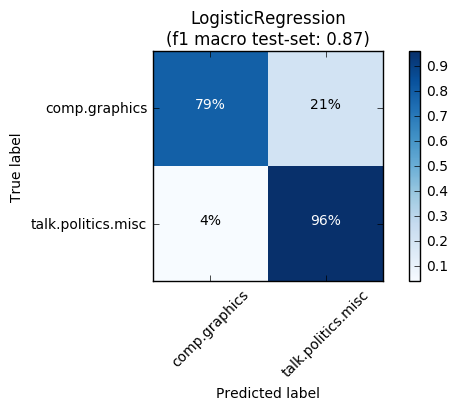

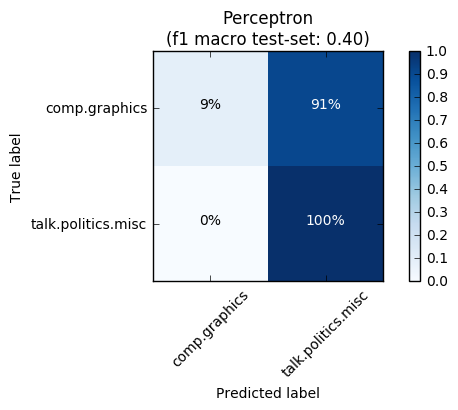

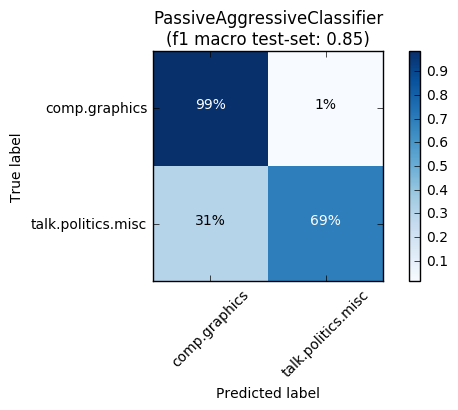

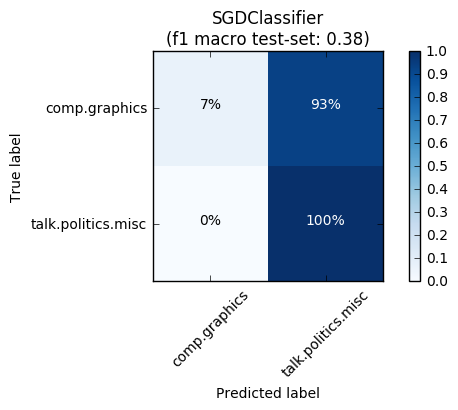

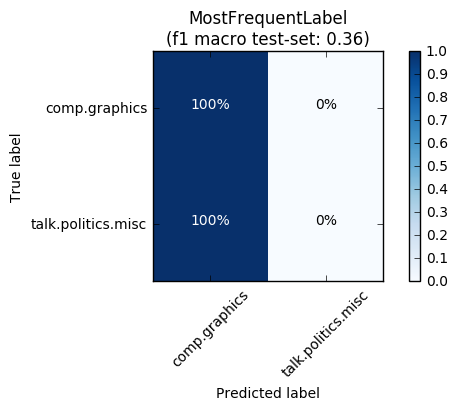

,LogisticRegression,MostFrequentLabel,PassiveAggressiveClassifier,Perceptron,SGDClassifier
test,0.865500,0.357537,0.846424,0.403308,0.380586
train,0.777085,0.357624,0.769204,0.320404,0.316640


In [180]:
clfs = {
    'PassiveAggressiveClassifier': sklearn.linear_model.PassiveAggressiveClassifier(),
    'Perceptron': sklearn.linear_model.Perceptron(n_iter = 1000),
    'LogisticRegression': sklearn.linear_model.LogisticRegression(max_iter = 1000),
    'SGDClassifier': sklearn.linear_model.SGDClassifier(n_iter = 1000),
    'MostFrequentLabel': ''
}

d2v_classification_predictions = {}
for clf_name, clf in clfs.items():
    # Just predict the most frequent label for all instances
    if clf_name == 'MostFrequentLabel':
        pred_train, pred_test = pred_train_baseline, pred_test_baseline
    else:
        pred_train, pred_test = fit_and_infer_d2v(clf)
        
    d2v_classification_predictions[clf_name] = {
        'pred_train': pred_train,
        'pred_test': pred_test
    }

results = {}
for clf_name, predictions in d2v_classification_predictions.items():
    pred_train, pred_test = predictions['pred_train'], predictions['pred_test']
    f1_score_train = metrics.f1_score(newsgroup_dataset_train.target, pred_train, average='macro')
    f1_score_test = metrics.f1_score(newsgroup_dataset_test.target, pred_test, average='macro')
    confusion_matrix = metrics.confusion_matrix(newsgroup_dataset_test.target, pred_test)
    class_report = metrics.classification_report(newsgroup_dataset_test.target, pred_test, target_names=newsgroup_dataset_test.target_names)
    results[clf_name] = {'train': f1_score_train, 'test': f1_score_test}
    plt.figure()
    plot_confusion_matrix(confusion_matrix, newsgroup_dataset_test.target_names, title = '{}\n(f1 macro test-set: {:.2f})'.format(clf_name, f1_score_test), normalize = True)
plt.show()

pd.DataFrame(results)